In [39]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [40]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, roc_curve, mean_squared_error
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
import xgboost as xgb
from tqdm.auto import tqdm
import re

In [41]:
data = "https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv"
cols = ["longitude", "latitude", "housing_median_age", "total_rooms", "total_bedrooms", "population", "households", 
               "median_income", "median_house_value", "ocean_proximity"]
df = pd.read_csv(data, usecols=cols)
df.total_bedrooms = df.total_bedrooms.fillna(0)

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20640 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [44]:
full_train, test = train_test_split(df, test_size=0.2, random_state=1)
train, val = train_test_split(full_train, test_size=0.25, random_state=1)

train = train.reset_index(drop=True)
val = val.reset_index(drop=True)
test = test.reset_index(drop=True)

y_train = np.log1p(train.median_house_value.values)
y_val = np.log1p(val.median_house_value.values)
y_test = np.log1p(test.median_house_value.values)

del train['median_house_value']
del val['median_house_value']
del test['median_house_value']

In [45]:
features = ["longitude", "latitude", "housing_median_age", "total_rooms", "total_bedrooms", "population", "households", 
               "median_income", "ocean_proximity"]

train_dicts = train[features].to_dict(orient='records')
val_dicts = val[features].to_dict(orient='records')

In [46]:
dv = DictVectorizer(sparse=False)

X_train = dv.fit_transform(train_dicts)
X_val = dv.transform(val_dicts)

# Question 1

In [47]:
model = DecisionTreeRegressor(max_depth=1)
model.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1)

In [48]:
from sklearn.tree import export_text

print(export_text(model, feature_names=dv.get_feature_names()))

|--- ocean_proximity=INLAND <= 0.50
|   |--- value: [12.31]
|--- ocean_proximity=INLAND >  0.50
|   |--- value: [11.61]



C:\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


# Question 2

In [49]:
model_rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
model_rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)

In [50]:
y_pred = model_rf.predict(X_val)

In [51]:
np.sqrt(mean_squared_error(y_pred, y_val))

0.2457383433183843

# Question 3

In [53]:
n_list = [x for x in range(10, 200, 10)]
n_list

rmse_score = list()

for n_est in tqdm(n_list):
    rf = RandomForestRegressor(n_estimators=n_est, random_state=1)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    rmse_score.append((n_est, rmse))
    
scores = pd.DataFrame(rmse_score, columns=['n_estimators', 'rmse'])

  0%|          | 0/19 [00:00<?, ?it/s]

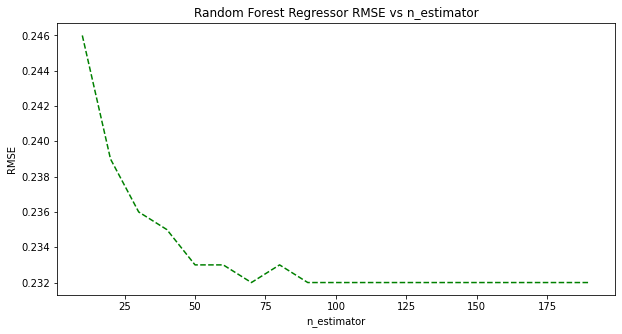

In [54]:
plt.figure(figsize=(10, 5))

plt.plot(scores.n_estimators, scores.rmse.round(3), color='green', linestyle='dashed')

plt.xlabel('n_estimator')
plt.ylabel('RMSE')

plt.title('Random Forest Regressor RMSE vs n_estimator')

plt.show()

# Question 4

In [55]:
scores = []

for depth in [10, 15, 20, 25]:

    for n_est in n_est_list:
        rf = RandomForestRegressor(n_estimators=n_est, random_state=1)
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_pred, y_val))
        scores.append((depth, n_est, rmse))

In [56]:
columns = ['depth', 'n_est', 'rmse']
df_scores = pd.DataFrame(scores, columns=columns)

df_scores_pivot = df_scores.pivot(index='n_est', columns=['depth'], values=['rmse'])
df_scores_pivot.round(3)

rmse                     
depth     10     15     20     25
n_est                            
10     0.246  0.246  0.246  0.246
20     0.239  0.239  0.239  0.239
30     0.236  0.236  0.236  0.236
40     0.235  0.235  0.235  0.235
50     0.233  0.233  0.233  0.233
60     0.233  0.233  0.233  0.233
70     0.232  0.232  0.232  0.232
80     0.233  0.233  0.233  0.233
90     0.232  0.232  0.232  0.232
100    0.232  0.232  0.232  0.232
110    0.232  0.232  0.232  0.232
120    0.232  0.232  0.232  0.232
130    0.232  0.232  0.232  0.232
140    0.232  0.232  0.232  0.232
150    0.232  0.232  0.232  0.232
160    0.232  0.232  0.232  0.232
170    0.232  0.232  0.232  0.232
180    0.232  0.232  0.232  0.232
190    0.232  0.232  0.232  0.232

<AxesSubplot:xlabel='None-depth', ylabel='n_est'>

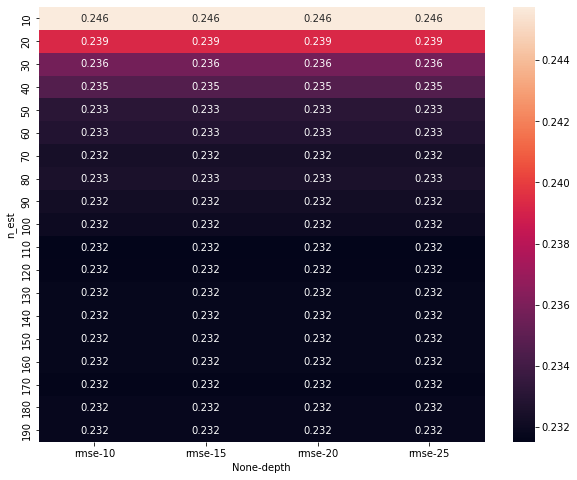

In [57]:
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(df_scores_pivot, annot=True, fmt=".3f")

# Question 5

In [58]:
rf = RandomForestRegressor(n_estimators=10, max_depth=20, random_state=1)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, n_estimators=10, random_state=1)

In [59]:
rf.feature_importances_

array([1.69573183e-02, 3.30938997e-02, 1.01333971e-01, 9.62649876e-02,
       3.62912907e-01, 3.00723750e-03, 3.10900842e-01, 3.56806263e-04,
       4.48661972e-04, 4.22762446e-03, 3.09180197e-02, 1.90412562e-02,
       2.05364687e-02])

In [60]:
df_importances = pd.DataFrame()
df_importances['feature'] = dv.get_feature_names()
df_importances['importance'] = rf.feature_importances_
df_importances

C:\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,feature,importance
0,households,0.016957
1,housing_median_age,0.033094
2,latitude,0.101334
3,longitude,0.096265
4,median_income,0.362913
5,ocean_proximity=<1H OCEAN,0.003007
6,ocean_proximity=INLAND,0.310901
7,ocean_proximity=ISLAND,0.000357
8,ocean_proximity=NEAR BAY,0.000449
9,ocean_proximity=NEAR OCEAN,0.004228


In [61]:
df_importances.sort_values(by="importance", ascending=False)

,feature,importance
4,median_income,0.362913
6,ocean_proximity=INLAND,0.310901
2,latitude,0.101334
3,longitude,0.096265
1,housing_median_age,0.033094
10,population,0.030918
12,total_rooms,0.020536
11,total_bedrooms,0.019041
0,households,0.016957
9,ocean_proximity=NEAR OCEAN,0.004228


# Question 6

In [62]:
features = dv.feature_names_

regex = re.compile(r"<", re.IGNORECASE)
features = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in features]

dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [63]:
dtrain

In [64]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [65]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_rmse', 'val_rmse']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [66]:
%%capture output

xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    'objective': 'reg:squarederror',
    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

# Train XGB model with the first params (eta=0.3)
model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                  verbose_eval=5, evals=watchlist)

In [67]:
xgb_out1 = parse_xgb_output(output)

In [68]:
%%capture output2

xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,
    'objective': 'reg:squarederror',
    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

# Train XGB model with the second params (eta=0.1)
model2 = xgb.train(xgb_params, dtrain, num_boost_round=100,
                  verbose_eval=5, evals=watchlist)

In [69]:
xgb_out2 = parse_xgb_output(output2)

In [70]:
# Output on XGB with eta=0.1
xgb_out2.tail()

,num_iter,train_rmse,val_rmse
16,80,0.19384,0.23398
17,85,0.19085,0.23275
18,90,0.18794,0.23206
19,95,0.18541,0.23106
20,99,0.18329,0.23054


In [71]:
# Output on XGB with eta=0.3
xgb_out1.tail()

,num_iter,train_rmse,val_rmse
16,80,0.14564,0.22611
17,85,0.14166,0.22579
18,90,0.13892,0.22628
19,95,0.13553,0.22630
20,99,0.13299,0.22610


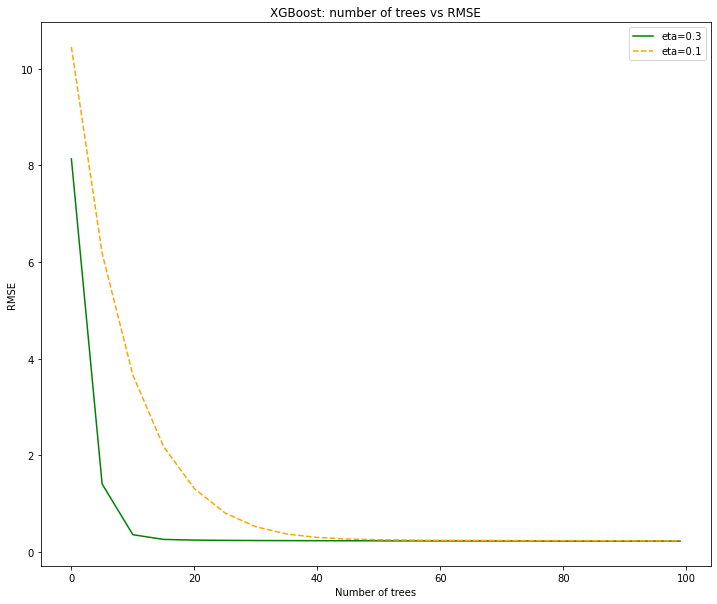

In [72]:
plt.figure(figsize=(12, 10))
plt.plot(xgb_out1.num_iter, xgb_out1.val_rmse, color="green", linestyle="solid", label='eta=0.3')
plt.plot(xgb_out2.num_iter, xgb_out2.val_rmse, color="orange", linestyle="dashed", label='eta=0.1')
plt.legend()

plt.title('XGBoost: number of trees vs RMSE')
plt.xlabel('Number of trees')
plt.ylabel('RMSE')


plt.show()